In [50]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from google.generativeai import list_models
import google.generativeai as genai
#from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

import os

In [51]:
load_dotenv()

True

In [ ]:
#model = ChatOpenAI(model= 'gpt-4o-mini')

#Get your GEMNAI_API_KEY
genai.configure(api_key=os.getenv("GEMNAI_API_KEY"))

for m in list_models():
    print(m.name)

In [ ]:
# Use a model that appears in your list (avoid older 1.5 names)
MODEL_NAME = "models/gemini-2.5-flash"   # or "models/gemini-2.5-pro"

model = ChatGoogleGenerativeAI(model=MODEL_NAME,api_key=gemini_key,)

resp = model.invoke("Write me a haiku about the stars.")
print(resp)        # LangChain Message object
print(resp.content)  # Just the text


In [54]:
class SentimentSchema(BaseModel):
    
    sentiment: Literal['positive', 'negative'] = Field(description="Sentiment of the review")

In [ ]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Others"] = Field(description= 'The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description= 'The emotional toe expresses by the user')
    urgency: Literal["low","medium","high"] = (description= "How urgent or critical the issue appear to be")
    

In [ ]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model = model.with_structured_output(DiagnosisSchema)

In [ ]:
prompt = 'What is the sentiment of the following review - The software is too bad'
structured_model.invoke(prompt).sentiment

In [ ]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: str
    response : str 

In [ ]:
def find_sentiment(state: ReviewState):

    prompt =  f'For the following review find out the sentiment\n{state["review"]}'
    
    sentiment = structured_model.invoke(prompt).sentiment
    
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState)-> Literal["positive_response", "run_diagnosis"]:
    
    if state['sentiment'] =='positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
    
def postive_response(state: ReviewState):
    
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\" \n
Also, kindly ask the user to leave feedback on our website"""


    response = model.invoke(prompt).content
     
    return {'response':response}
def run_diagnosis(state: ReviewState):
    prompt = f"Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency."
    
    response = structured_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}
    
    
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}'issue,sounded'{diagnosis['tone']}, and marked urgency as
    Wrie an empathetic,helpful resolution message."""


    response = model.invoke(prompt).content
    
    return   {'response': response}



In [ ]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis )
graph.add_node('negative_response', negative_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edge('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', negative_response)
graph.add_edge(' negative_response', END)

workflow = graph.compile()

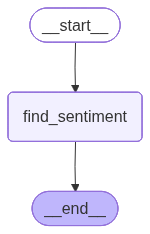

In [45]:
workflow

In [ ]:
#initial_state = {"review" : 'The product was really good'}
initial_state = {"review" :"I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial Great job to the design team!"}
workflow.invoke(initial_state)

{'review': 'The product was really bad', 'sentiment': 'negative'}